In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2
import torchvision
import random 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import shutil
shutil.copy('/content/drive/Shareddrives/CV/cnn/test.zip', 'test.zip')
shutil.copy('/content/drive/Shareddrives/CV/cnn/train.zip', 'train.zip')
!unzip test.zip
!unzip train.zip 

Streaming output truncated to the last 5000 lines.
  inflating: train/cnn5008.data      
  inflating: train/cnn5009.data      
  inflating: train/cnn501.data       
  inflating: train/cnn5010.data      
  inflating: train/cnn5011.data      
  inflating: train/cnn5013.data      
  inflating: train/cnn5014.data      
  inflating: train/cnn5015.data      
  inflating: train/cnn5016.data      
  inflating: train/cnn5017.data      
  inflating: train/cnn5018.data      
  inflating: train/cnn5019.data      
  inflating: train/cnn502.data       
  inflating: train/cnn5021.data      
  inflating: train/cnn5022.data      
  inflating: train/cnn5023.data      
  inflating: train/cnn5024.data      
  inflating: train/cnn5025.data      
  inflating: train/cnn5027.data      
  inflating: train/cnn5029.data      
  inflating: train/cnn503.data       
  inflating: train/cnn5030.data      
  inflating: train/cnn5031.data      
  inflating: train/cnn5032.data      
  inflating: train/cnn5033.data      

In [ ]:
shutil.copy('/content/drive/Shareddrives/CV/cnn/test.csv', 'test.csv')
shutil.copy('/content/drive/Shareddrives/CV/cnn/train.csv', 'train.csv')

'train.csv'

In [ ]:
def get_random_crop(image, crop_height, crop_width):
    
    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height
    # print(image.shape[1])
    # print(image.shape[0])
    # print(max_x)
    # print(max_y)

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop

In [ ]:
class XRayCNNDataset(Dataset):
    # root_dir example: r'D:xray/cnn/train'
    # annotation_file example: r'train.csv'
    def __init__(self, root_dir, annotation_file, augment=0):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.augment = augment
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        file_name = self.annotations._get_value(index, 'image_id')
        label = self.annotations._get_value(index, 'class_id')
        file = open(os.path.join(self.root_dir, file_name), 'rb')
        img = pickle.load(file) 
        img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
        if self.augment == 1:
          if random.random() < 0.5:
            np.fliplr(img)
          img = cv2.copyMakeBorder(img, 4,4,4,4, cv2.BORDER_REFLECT)
          img = get_random_crop(img, 128, 128)
        img = np.array([img.copy(), img.copy(), img.copy()])
#  from PIL import Image 
# imgs_a.append(Image.open(os.path.join(self.path_a, dirname, filename_a)).convert(self.mode_a))
# transformed = self.transforms(*imgs_a, *imgs_b)
#        img = np.array([pickle.load(file)])
        file.close()
        img = img.astype('float32')
        return (img, label)

In [ ]:
def get_data(batch_size=128, augmentation = 0):
    trainset = XRayCNNDataset(r'/content/train', '/content/train.csv' ,augment = 1)
    trainloader  = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    testset = XRayCNNDataset(r'/content/test', '/content/test.csv')
    testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True)
    
    classes = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
               'Consolidation', 'ILD', 'Inflitration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion',
               'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
    return {'train': trainloader, 'test': testloader, 'classes': classes}

data = get_data(batch_size = 32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=0):
    net.to(device)
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    for epoch in tqdm(range(epochs)):
        sum_loss = 0.0
        for i, batch in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            # print statistics
            losses.append(loss.item())
            sum_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
    return losses

def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0/3 [00:00<?, ?it/s]

[1,   100] loss: 1.509
[1,   200] loss: 1.107
[1,   300] loss: 1.067
[1,   400] loss: 0.958
[1,   500] loss: 0.962
[1,   600] loss: 0.901
[1,   700] loss: 0.904
[1,   800] loss: 0.857
[1,   900] loss: 0.866
[1,  1000] loss: 0.818


 33%|███▎      | 1/3 [04:28<08:56, 268.47s/it]

[2,   100] loss: 0.951
[2,   200] loss: 0.799
[2,   300] loss: 0.817
[2,   400] loss: 0.786
[2,   500] loss: 0.815
[2,   600] loss: 0.786
[2,   700] loss: 0.777
[2,   800] loss: 0.790
[2,   900] loss: 0.761
[2,  1000] loss: 0.731


 67%|██████▋   | 2/3 [09:06<04:31, 271.31s/it]

[3,   100] loss: 0.760
[3,   200] loss: 0.735
[3,   300] loss: 0.706
[3,   400] loss: 0.722
[3,   500] loss: 0.726
[3,   600] loss: 0.688
[3,   700] loss: 0.712
[3,   800] loss: 0.681
[3,   900] loss: 0.694
[3,  1000] loss: 0.719


100%|██████████| 3/3 [13:44<00:00, 274.79s/it]


Training accuracy: 0.768429
Testing accuracy: 0.738312


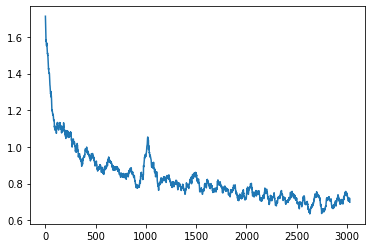

In [ ]:
#resnet transfer learning 
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
#print(resnet)
resnet.fc = nn.Linear(2048, 14) # Reinitializes final layer, assigns random weights

resnet_losses = train(resnet, data['train'], epochs=3, lr=.01, verbose = 1, decay = 0.0005)

print("Training accuracy: %f" % accuracy(resnet, data['train']))
print("Testing accuracy: %f" % accuracy(resnet, data['test']))

plt.plot(smooth(resnet_losses,50))

In [ ]:
resnet_losses += train(resnet, data['train'], epochs=1, lr=.0001, verbose = 1, decay = 0.0005)
# resnet_losses += train(resnet, data['train'], epochs=10, lr=.001, verbose = 1)
# resnet_losses += train(resnet, data['train'], epochs=10, lr=.0001, verbose = 1)
print("Training accuracy: %f" % accuracy(resnet, data['train']))
print("Testing accuracy: %f" % accuracy(resnet, data['test']))

  0%|          | 0/1 [00:00<?, ?it/s]

[1,   100] loss: 0.620
[1,   200] loss: 0.640
[1,   300] loss: 0.622
[1,   400] loss: 0.609
[1,   500] loss: 0.597
[1,   600] loss: 0.612
[1,   700] loss: 0.607
[1,   800] loss: 0.571
[1,   900] loss: 0.592
[1,  1000] loss: 0.623


100%|██████████| 1/1 [04:31<00:00, 271.53s/it]


Training accuracy: 0.786781
Testing accuracy: 0.744991


  0%|          | 0/1 [00:00<?, ?it/s]

[1,   100] loss: 0.618
[1,   200] loss: 0.599
[1,   300] loss: 0.592
[1,   400] loss: 0.581
[1,   500] loss: 0.565
[1,   600] loss: 0.563
[1,   700] loss: 0.605
[1,   800] loss: 0.553
[1,   900] loss: 0.558
[1,  1000] loss: 0.579


100%|██████████| 1/1 [04:33<00:00, 273.60s/it]


Training accuracy: 0.787940
Testing accuracy: 0.747723


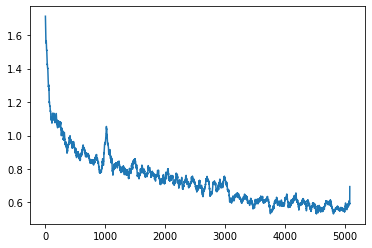

In [ ]:
resnet_losses += train(resnet, data['train'], epochs=1, lr=.00001, verbose = 1)
print("Training accuracy: %f" % accuracy(resnet, data['train']))
print("Testing accuracy: %f" % accuracy(resnet, data['test']))

plt.plot(smooth(resnet_losses,50))

In [ ]:
print("Training accuracy: %f" % accuracy(resnet, data['train']))
print("Testing accuracy: %f" % accuracy(resnet, data['test']))

Training accuracy: 0.787665
Testing accuracy: 0.746812


  0%|          | 0/1 [00:00<?, ?it/s]

[1,   100] loss: 0.571
[1,   200] loss: 0.571
[1,   300] loss: 0.597
[1,   400] loss: 0.591
[1,   500] loss: 0.580
[1,   600] loss: 0.580
[1,   700] loss: 0.557
[1,   800] loss: 0.572
[1,   900] loss: 0.584
[1,  1000] loss: 0.587


100%|██████████| 1/1 [04:33<00:00, 273.94s/it]


Training accuracy: 0.786385
Testing accuracy: 0.754098


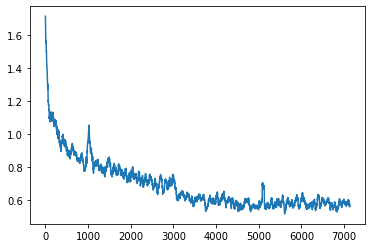

In [ ]:
resnet_losses += train(resnet, data['train'], epochs=1, lr=.0000001, verbose = 1)
print("Training accuracy: %f" % accuracy(resnet, data['train']))
print("Testing accuracy: %f" % accuracy(resnet, data['test']))

plt.plot(smooth(resnet_losses,50))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0/10 [00:00<?, ?it/s]

[1,   100] loss: 3.209
[1,   200] loss: 2.064
[1,   300] loss: 1.849
[1,   400] loss: 1.752
[1,   500] loss: 1.682
[1,   600] loss: 1.655
[1,   700] loss: 1.584
[1,   800] loss: 1.528
[1,   900] loss: 1.538
[1,  1000] loss: 1.478


 10%|█         | 1/10 [00:32<04:50, 32.30s/it]

[2,   100] loss: 1.438
[2,   200] loss: 1.476
[2,   300] loss: 1.489
[2,   400] loss: 1.441
[2,   500] loss: 1.387
[2,   600] loss: 1.410
[2,   700] loss: 1.415
[2,   800] loss: 1.392
[2,   900] loss: 1.392
[2,  1000] loss: 1.357


 20%|██        | 2/10 [01:04<04:18, 32.26s/it]

[3,   100] loss: 1.369
[3,   200] loss: 1.362
[3,   300] loss: 1.330
[3,   400] loss: 1.321
[3,   500] loss: 1.341
[3,   600] loss: 1.335
[3,   700] loss: 1.357
[3,   800] loss: 1.311
[3,   900] loss: 1.329
[3,  1000] loss: 1.314


 30%|███       | 3/10 [01:36<03:46, 32.29s/it]

[4,   100] loss: 1.282
[4,   200] loss: 1.288
[4,   300] loss: 1.309
[4,   400] loss: 1.245
[4,   500] loss: 1.242
[4,   600] loss: 1.254
[4,   700] loss: 1.318
[4,   800] loss: 1.292
[4,   900] loss: 1.275
[4,  1000] loss: 1.278


 40%|████      | 4/10 [02:09<03:13, 32.32s/it]

[5,   100] loss: 1.232
[5,   200] loss: 1.256
[5,   300] loss: 1.267
[5,   400] loss: 1.260
[5,   500] loss: 1.247
[5,   600] loss: 1.213
[5,   700] loss: 1.216
[5,   800] loss: 1.253
[5,   900] loss: 1.248
[5,  1000] loss: 1.258


 50%|█████     | 5/10 [02:41<02:41, 32.34s/it]

[6,   100] loss: 1.231
[6,   200] loss: 1.205
[6,   300] loss: 1.206
[6,   400] loss: 1.199
[6,   500] loss: 1.204
[6,   600] loss: 1.200
[6,   700] loss: 1.214
[6,   800] loss: 1.224
[6,   900] loss: 1.204
[6,  1000] loss: 1.224


 60%|██████    | 6/10 [03:13<02:09, 32.36s/it]

[7,   100] loss: 1.254
[7,   200] loss: 1.228
[7,   300] loss: 1.163
[7,   400] loss: 1.205
[7,   500] loss: 1.221
[7,   600] loss: 1.157
[7,   700] loss: 1.151
[7,   800] loss: 1.207
[7,   900] loss: 1.217
[7,  1000] loss: 1.120


 70%|███████   | 7/10 [03:46<01:37, 32.37s/it]

[8,   100] loss: 1.179
[8,   200] loss: 1.143
[8,   300] loss: 1.161
[8,   400] loss: 1.199
[8,   500] loss: 1.171
[8,   600] loss: 1.189
[8,   700] loss: 1.177
[8,   800] loss: 1.159
[8,   900] loss: 1.189
[8,  1000] loss: 1.125


 80%|████████  | 8/10 [04:19<01:04, 32.45s/it]

[9,   100] loss: 1.190
[9,   200] loss: 1.166
[9,   300] loss: 1.169
[9,   400] loss: 1.152
[9,   500] loss: 1.158
[9,   600] loss: 1.179
[9,   700] loss: 1.137
[9,   800] loss: 1.135
[9,   900] loss: 1.115
[9,  1000] loss: 1.125


 90%|█████████ | 9/10 [04:51<00:32, 32.45s/it]

[10,   100] loss: 1.167
[10,   200] loss: 1.166
[10,   300] loss: 1.107
[10,   400] loss: 1.153
[10,   500] loss: 1.131
[10,   600] loss: 1.140
[10,   700] loss: 1.150
[10,   800] loss: 1.103
[10,   900] loss: 1.128
[10,  1000] loss: 1.103


100%|██████████| 10/10 [05:23<00:00, 32.39s/it]


Training accuracy: 0.626059
Testing accuracy: 0.619611


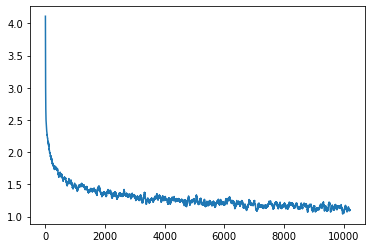

In [ ]:
#Alex Net transfer learning 
alexnet_model = torchvision.models.alexnet(pretrained=True)
for param in alexnet_model.parameters():
  param.requires_grad = True
alexnet_model.classifier[6] = nn.Linear(4096, 14)

alexnet_losses = train(alexnet_model, data['train'], epochs=10, lr=.00001, verbose = 1, decay = 0.0005)

print("Training accuracy: %f" % accuracy(alexnet_model, data['train']))
print("Testing accuracy: %f" % accuracy(alexnet_model, data['test']))

plt.plot(smooth(alexnet_losses,50))

In [ ]:

alexnet_losses = train(alexnet_model, data['train'], epochs=10, lr=.0000001, verbose = 1, decay = 0.0005)

print("Training accuracy: %f" % accuracy(alexnet_model, data['train']))
print("Testing accuracy: %f" % accuracy(alexnet_model, data['test']))

  0%|          | 0/10 [00:00<?, ?it/s]

[1,   100] loss: 1.124
[1,   200] loss: 1.080
[1,   300] loss: 1.122
[1,   400] loss: 1.067
[1,   500] loss: 1.164
[1,   600] loss: 1.108
[1,   700] loss: 1.091
[1,   800] loss: 1.108
[1,   900] loss: 1.113
[1,  1000] loss: 1.121


 10%|█         | 1/10 [00:32<04:50, 32.33s/it]

[2,   100] loss: 1.111
[2,   200] loss: 1.125
[2,   300] loss: 1.128
[2,   400] loss: 1.108
[2,   500] loss: 1.121
[2,   600] loss: 1.088
[2,   700] loss: 1.090
[2,   800] loss: 1.078
[2,   900] loss: 1.088
[2,  1000] loss: 1.119


 20%|██        | 2/10 [01:04<04:18, 32.32s/it]

[3,   100] loss: 1.094
[3,   200] loss: 1.070
[3,   300] loss: 1.091
[3,   400] loss: 1.101
[3,   500] loss: 1.130
[3,   600] loss: 1.092
[3,   700] loss: 1.128
[3,   800] loss: 1.094
[3,   900] loss: 1.122
[3,  1000] loss: 1.066


 30%|███       | 3/10 [01:36<03:46, 32.33s/it]

[4,   100] loss: 1.068
[4,   200] loss: 1.100
[4,   300] loss: 1.099
[4,   400] loss: 1.096
[4,   500] loss: 1.126
[4,   600] loss: 1.118
[4,   700] loss: 1.105
[4,   800] loss: 1.097
[4,   900] loss: 1.090
[4,  1000] loss: 1.088


 40%|████      | 4/10 [02:09<03:14, 32.34s/it]

[5,   100] loss: 1.101
[5,   200] loss: 1.113
[5,   300] loss: 1.107
[5,   400] loss: 1.104
[5,   500] loss: 1.096
[5,   600] loss: 1.049
[5,   700] loss: 1.138
[5,   800] loss: 1.098
[5,   900] loss: 1.083
[5,  1000] loss: 1.118


 50%|█████     | 5/10 [02:41<02:42, 32.42s/it]

[6,   100] loss: 1.079
[6,   200] loss: 1.067
[6,   300] loss: 1.110
[6,   400] loss: 1.110
[6,   500] loss: 1.073
[6,   600] loss: 1.114
[6,   700] loss: 1.136
[6,   800] loss: 1.088
[6,   900] loss: 1.103
[6,  1000] loss: 1.080


 60%|██████    | 6/10 [03:14<02:09, 32.41s/it]

[7,   100] loss: 1.103
[7,   200] loss: 1.095
[7,   300] loss: 1.141
[7,   400] loss: 1.106
[7,   500] loss: 1.068
[7,   600] loss: 1.101
[7,   700] loss: 1.075
[7,   800] loss: 1.100
[7,   900] loss: 1.129
[7,  1000] loss: 1.079


 70%|███████   | 7/10 [03:46<01:37, 32.41s/it]

[8,   100] loss: 1.134
[8,   200] loss: 1.099
[8,   300] loss: 1.107
[8,   400] loss: 1.094
[8,   500] loss: 1.077
[8,   600] loss: 1.104
[8,   700] loss: 1.078
[8,   800] loss: 1.069
[8,   900] loss: 1.086
[8,  1000] loss: 1.137


 80%|████████  | 8/10 [04:19<01:04, 32.41s/it]

[9,   100] loss: 1.074
[9,   200] loss: 1.100
[9,   300] loss: 1.088
[9,   400] loss: 1.085
[9,   500] loss: 1.077
[9,   600] loss: 1.112
[9,   700] loss: 1.092
[9,   800] loss: 1.106
[9,   900] loss: 1.071
[9,  1000] loss: 1.130


 90%|█████████ | 9/10 [04:51<00:32, 32.40s/it]

[10,   100] loss: 1.083
[10,   200] loss: 1.137
[10,   300] loss: 1.112
[10,   400] loss: 1.082
[10,   500] loss: 1.098
[10,   600] loss: 1.089
[10,   700] loss: 1.104
[10,   800] loss: 1.090
[10,   900] loss: 1.105
[10,  1000] loss: 1.052


100%|██████████| 10/10 [05:23<00:00, 32.40s/it]


Training accuracy: 0.645266
Testing accuracy: 0.639041


  0%|          | 0/20 [00:00<?, ?it/s]

[1,   100] loss: 1.104
[1,   200] loss: 1.111
[1,   300] loss: 1.085
[1,   400] loss: 1.122
[1,   500] loss: 1.078
[1,   600] loss: 1.099
[1,   700] loss: 1.122
[1,   800] loss: 1.035
[1,   900] loss: 1.081
[1,  1000] loss: 1.080


  5%|▌         | 1/20 [00:32<10:12, 32.22s/it]

[2,   100] loss: 1.058
[2,   200] loss: 1.093
[2,   300] loss: 1.098
[2,   400] loss: 1.117
[2,   500] loss: 1.092
[2,   600] loss: 1.075
[2,   700] loss: 1.089
[2,   800] loss: 1.127
[2,   900] loss: 1.087
[2,  1000] loss: 1.111


 10%|█         | 2/20 [01:04<09:39, 32.21s/it]

[3,   100] loss: 1.113
[3,   200] loss: 1.103
[3,   300] loss: 1.110
[3,   400] loss: 1.094
[3,   500] loss: 1.157
[3,   600] loss: 1.097
[3,   700] loss: 1.067
[3,   800] loss: 1.087
[3,   900] loss: 1.067
[3,  1000] loss: 1.091


 15%|█▌        | 3/20 [01:36<09:08, 32.24s/it]

[4,   100] loss: 1.114
[4,   200] loss: 1.132
[4,   300] loss: 1.075
[4,   400] loss: 1.096
[4,   500] loss: 1.075
[4,   600] loss: 1.105
[4,   700] loss: 1.088
[4,   800] loss: 1.079
[4,   900] loss: 1.104
[4,  1000] loss: 1.082


 20%|██        | 4/20 [02:09<08:37, 32.32s/it]

[5,   100] loss: 1.073
[5,   200] loss: 1.088
[5,   300] loss: 1.120
[5,   400] loss: 1.091
[5,   500] loss: 1.101
[5,   600] loss: 1.058
[5,   700] loss: 1.086
[5,   800] loss: 1.136
[5,   900] loss: 1.076
[5,  1000] loss: 1.115


 25%|██▌       | 5/20 [02:41<08:05, 32.34s/it]

[6,   100] loss: 1.090
[6,   200] loss: 1.078
[6,   300] loss: 1.128
[6,   400] loss: 1.102
[6,   500] loss: 1.080
[6,   600] loss: 1.063
[6,   700] loss: 1.074
[6,   800] loss: 1.092
[6,   900] loss: 1.099
[6,  1000] loss: 1.121


 30%|███       | 6/20 [03:14<07:33, 32.37s/it]

[7,   100] loss: 1.080
[7,   200] loss: 1.092
[7,   300] loss: 1.119
[7,   400] loss: 1.113
[7,   500] loss: 1.076
[7,   600] loss: 1.078
[7,   700] loss: 1.119
[7,   800] loss: 1.109
[7,   900] loss: 1.068
[7,  1000] loss: 1.087


 35%|███▌      | 7/20 [03:46<07:00, 32.36s/it]

[8,   100] loss: 1.101
[8,   200] loss: 1.109
[8,   300] loss: 1.123
[8,   400] loss: 1.087
[8,   500] loss: 1.080
[8,   600] loss: 1.156
[8,   700] loss: 1.063
[8,   800] loss: 1.056
[8,   900] loss: 1.061
[8,  1000] loss: 1.114


 40%|████      | 8/20 [04:18<06:28, 32.38s/it]

[9,   100] loss: 1.029
[9,   200] loss: 1.130
[9,   300] loss: 1.106
[9,   400] loss: 1.082
[9,   500] loss: 1.106
[9,   600] loss: 1.099
[9,   700] loss: 1.098
[9,   800] loss: 1.129
[9,   900] loss: 1.081
[9,  1000] loss: 1.104


 45%|████▌     | 9/20 [04:51<05:56, 32.39s/it]

[10,   100] loss: 1.065
[10,   200] loss: 1.085
[10,   300] loss: 1.121
[10,   400] loss: 1.088
[10,   500] loss: 1.076
[10,   600] loss: 1.113
[10,   700] loss: 1.101
[10,   800] loss: 1.105
[10,   900] loss: 1.107
[10,  1000] loss: 1.052


 50%|█████     | 10/20 [05:23<05:24, 32.41s/it]

[11,   100] loss: 1.124
[11,   200] loss: 1.098
[11,   300] loss: 1.071
[11,   400] loss: 1.087
[11,   500] loss: 1.107
[11,   600] loss: 1.077
[11,   700] loss: 1.067
[11,   800] loss: 1.123
[11,   900] loss: 1.085
[11,  1000] loss: 1.080


 55%|█████▌    | 11/20 [05:56<04:51, 32.41s/it]

[12,   100] loss: 1.081
[12,   200] loss: 1.110
[12,   300] loss: 1.120
[12,   400] loss: 1.119
[12,   500] loss: 1.084
[12,   600] loss: 1.073
[12,   700] loss: 1.069
[12,   800] loss: 1.099
[12,   900] loss: 1.070
[12,  1000] loss: 1.073


 60%|██████    | 12/20 [06:28<04:19, 32.41s/it]

[13,   100] loss: 1.095
[13,   200] loss: 1.080
[13,   300] loss: 1.155
[13,   400] loss: 1.074
[13,   500] loss: 1.051
[13,   600] loss: 1.078
[13,   700] loss: 1.070
[13,   800] loss: 1.123
[13,   900] loss: 1.072
[13,  1000] loss: 1.068


 65%|██████▌   | 13/20 [07:01<03:47, 32.44s/it]

[14,   100] loss: 1.068
[14,   200] loss: 1.093
[14,   300] loss: 1.125
[14,   400] loss: 1.076
[14,   500] loss: 1.105
[14,   600] loss: 1.106
[14,   700] loss: 1.069
[14,   800] loss: 1.074
[14,   900] loss: 1.114
[14,  1000] loss: 1.079


 70%|███████   | 14/20 [07:33<03:14, 32.44s/it]

[15,   100] loss: 1.137
[15,   200] loss: 1.124
[15,   300] loss: 1.115
[15,   400] loss: 1.050
[15,   500] loss: 1.059
[15,   600] loss: 1.092
[15,   700] loss: 1.111
[15,   800] loss: 1.069
[15,   900] loss: 1.083
[15,  1000] loss: 1.066


 75%|███████▌  | 15/20 [08:05<02:42, 32.45s/it]

[16,   100] loss: 1.088
[16,   200] loss: 1.094
[16,   300] loss: 1.068
[16,   400] loss: 1.100
[16,   500] loss: 1.108
[16,   600] loss: 1.086
[16,   700] loss: 1.077
[16,   800] loss: 1.074
[16,   900] loss: 1.106
[16,  1000] loss: 1.109


 80%|████████  | 16/20 [08:38<02:09, 32.45s/it]

[17,   100] loss: 1.105
[17,   200] loss: 1.071
[17,   300] loss: 1.083
[17,   400] loss: 1.119
[17,   500] loss: 1.117
[17,   600] loss: 1.128
[17,   700] loss: 1.088
[17,   800] loss: 1.087
[17,   900] loss: 1.074
[17,  1000] loss: 1.065


 85%|████████▌ | 17/20 [09:10<01:37, 32.46s/it]

[18,   100] loss: 1.137
[18,   200] loss: 1.127
[18,   300] loss: 1.094
[18,   400] loss: 1.074
[18,   500] loss: 1.063
[18,   600] loss: 1.101
[18,   700] loss: 1.121
[18,   800] loss: 1.075
[18,   900] loss: 1.055
[18,  1000] loss: 1.088


 90%|█████████ | 18/20 [09:43<01:04, 32.48s/it]

[19,   100] loss: 1.054
[19,   200] loss: 1.052
[19,   300] loss: 1.130
[19,   400] loss: 1.096
[19,   500] loss: 1.068
[19,   600] loss: 1.111
[19,   700] loss: 1.084
[19,   800] loss: 1.105
[19,   900] loss: 1.121
[19,  1000] loss: 1.086


 95%|█████████▌| 19/20 [10:15<00:32, 32.52s/it]

[20,   100] loss: 1.121
[20,   200] loss: 1.096
[20,   300] loss: 1.131
[20,   400] loss: 1.088
[20,   500] loss: 1.100
[20,   600] loss: 1.076
[20,   700] loss: 1.063
[20,   800] loss: 1.104
[20,   900] loss: 1.098
[20,  1000] loss: 1.068


100%|██████████| 20/20 [10:48<00:00, 32.42s/it]


Training accuracy: 0.645845


  0%|          | 0/20 [00:00<?, ?it/s]

Testing accuracy: 0.643291
[1,   100] loss: 1.040
[1,   200] loss: 1.077
[1,   300] loss: 1.070
[1,   400] loss: 1.111
[1,   500] loss: 1.133
[1,   600] loss: 1.091
[1,   700] loss: 1.090
[1,   800] loss: 1.119
[1,   900] loss: 1.081
[1,  1000] loss: 1.112


  5%|▌         | 1/20 [00:32<10:16, 32.45s/it]

[2,   100] loss: 1.037
[2,   200] loss: 1.111
[2,   300] loss: 1.124
[2,   400] loss: 1.074
[2,   500] loss: 1.091
[2,   600] loss: 1.061
[2,   700] loss: 1.087
[2,   800] loss: 1.104
[2,   900] loss: 1.084
[2,  1000] loss: 1.089


 10%|█         | 2/20 [01:04<09:44, 32.47s/it]

[3,   100] loss: 1.097
[3,   200] loss: 1.096
[3,   300] loss: 1.102
[3,   400] loss: 1.063
[3,   500] loss: 1.095
[3,   600] loss: 1.082
[3,   700] loss: 1.087
[3,   800] loss: 1.082
[3,   900] loss: 1.112
[3,  1000] loss: 1.099


 15%|█▌        | 3/20 [01:37<09:12, 32.50s/it]

[4,   100] loss: 1.076
[4,   200] loss: 1.074
[4,   300] loss: 1.084
[4,   400] loss: 1.076
[4,   500] loss: 1.108
[4,   600] loss: 1.101
[4,   700] loss: 1.089
[4,   800] loss: 1.127
[4,   900] loss: 1.085
[4,  1000] loss: 1.100


 20%|██        | 4/20 [02:09<08:39, 32.49s/it]

[5,   100] loss: 1.071
[5,   200] loss: 1.113
[5,   300] loss: 1.082
[5,   400] loss: 1.089
[5,   500] loss: 1.093
[5,   600] loss: 1.060
[5,   700] loss: 1.098
[5,   800] loss: 1.119
[5,   900] loss: 1.082
[5,  1000] loss: 1.099


 25%|██▌       | 5/20 [02:42<08:07, 32.50s/it]

[6,   100] loss: 1.090
[6,   200] loss: 1.101
[6,   300] loss: 1.061
[6,   400] loss: 1.093
[6,   500] loss: 1.074
[6,   600] loss: 1.096
[6,   700] loss: 1.122
[6,   800] loss: 1.085
[6,   900] loss: 1.082
[6,  1000] loss: 1.120


 30%|███       | 6/20 [03:14<07:34, 32.48s/it]

[7,   100] loss: 1.095
[7,   200] loss: 1.102
[7,   300] loss: 1.078
[7,   400] loss: 1.079
[7,   500] loss: 1.069
[7,   600] loss: 1.136
[7,   700] loss: 1.067
[7,   800] loss: 1.076
[7,   900] loss: 1.113
[7,  1000] loss: 1.058


 35%|███▌      | 7/20 [03:47<07:02, 32.48s/it]

[8,   100] loss: 1.097
[8,   200] loss: 1.121
[8,   300] loss: 1.087
[8,   400] loss: 1.114
[8,   500] loss: 1.074
[8,   600] loss: 1.074
[8,   700] loss: 1.104
[8,   800] loss: 1.086
[8,   900] loss: 1.042
[8,  1000] loss: 1.075


 40%|████      | 8/20 [04:20<06:30, 32.55s/it]

[9,   100] loss: 1.072
[9,   200] loss: 1.075
[9,   300] loss: 1.057
[9,   400] loss: 1.126
[9,   500] loss: 1.107
[9,   600] loss: 1.063
[9,   700] loss: 1.075
[9,   800] loss: 1.079
[9,   900] loss: 1.096
[9,  1000] loss: 1.112


 45%|████▌     | 9/20 [04:52<05:57, 32.53s/it]

[10,   100] loss: 1.059
[10,   200] loss: 1.110
[10,   300] loss: 1.094
[10,   400] loss: 1.075
[10,   500] loss: 1.089
[10,   600] loss: 1.077
[10,   700] loss: 1.103
[10,   800] loss: 1.087
[10,   900] loss: 1.128
[10,  1000] loss: 1.085


 50%|█████     | 10/20 [05:25<05:25, 32.51s/it]

[11,   100] loss: 1.121
[11,   200] loss: 1.070
[11,   300] loss: 1.081
[11,   400] loss: 1.088
[11,   500] loss: 1.094
[11,   600] loss: 1.118
[11,   700] loss: 1.086
[11,   800] loss: 1.066
[11,   900] loss: 1.109
[11,  1000] loss: 1.089


 55%|█████▌    | 11/20 [05:57<04:52, 32.49s/it]

[12,   100] loss: 1.099
[12,   200] loss: 1.080
[12,   300] loss: 1.123
[12,   400] loss: 1.094
[12,   500] loss: 1.115
[12,   600] loss: 1.118
[12,   700] loss: 1.027
[12,   800] loss: 1.095
[12,   900] loss: 1.063
[12,  1000] loss: 1.078


 60%|██████    | 12/20 [06:30<04:20, 32.51s/it]

[13,   100] loss: 1.094
[13,   200] loss: 1.059
[13,   300] loss: 1.092
[13,   400] loss: 1.125
[13,   500] loss: 1.076
[13,   600] loss: 1.103
[13,   700] loss: 1.053
[13,   800] loss: 1.082
[13,   900] loss: 1.077
[13,  1000] loss: 1.103


 65%|██████▌   | 13/20 [07:02<03:47, 32.49s/it]

[14,   100] loss: 1.067
[14,   200] loss: 1.088
[14,   300] loss: 1.099
[14,   400] loss: 1.056
[14,   500] loss: 1.106
[14,   600] loss: 1.108
[14,   700] loss: 1.079
[14,   800] loss: 1.086
[14,   900] loss: 1.091
[14,  1000] loss: 1.104


 70%|███████   | 14/20 [07:35<03:14, 32.49s/it]

[15,   100] loss: 1.093
[15,   200] loss: 1.083
[15,   300] loss: 1.086
[15,   400] loss: 1.103
[15,   500] loss: 1.085
[15,   600] loss: 1.081
[15,   700] loss: 1.084
[15,   800] loss: 1.087
[15,   900] loss: 1.084
[15,  1000] loss: 1.086


 75%|███████▌  | 15/20 [08:07<02:42, 32.49s/it]

[16,   100] loss: 1.069
[16,   200] loss: 1.098
[16,   300] loss: 1.133
[16,   400] loss: 1.073
[16,   500] loss: 1.105
[16,   600] loss: 1.088
[16,   700] loss: 1.079
[16,   800] loss: 1.097
[16,   900] loss: 1.083
[16,  1000] loss: 1.083


 80%|████████  | 16/20 [08:40<02:10, 32.54s/it]

[17,   100] loss: 1.091
[17,   200] loss: 1.075
[17,   300] loss: 1.015
[17,   400] loss: 1.130
[17,   500] loss: 1.092
[17,   600] loss: 1.088
[17,   700] loss: 1.109
[17,   800] loss: 1.086
[17,   900] loss: 1.092
[17,  1000] loss: 1.093


 85%|████████▌ | 17/20 [09:12<01:37, 32.52s/it]

[18,   100] loss: 1.119
[18,   200] loss: 1.069
[18,   300] loss: 1.056
[18,   400] loss: 1.087
[18,   500] loss: 1.099
[18,   600] loss: 1.084
[18,   700] loss: 1.090
[18,   800] loss: 1.116
[18,   900] loss: 1.122
[18,  1000] loss: 1.093


 90%|█████████ | 18/20 [09:45<01:05, 32.50s/it]

[19,   100] loss: 1.131
[19,   200] loss: 1.072
[19,   300] loss: 1.121
[19,   400] loss: 1.105
[19,   500] loss: 1.098
[19,   600] loss: 1.064
[19,   700] loss: 1.067
[19,   800] loss: 1.055
[19,   900] loss: 1.095
[19,  1000] loss: 1.099


 95%|█████████▌| 19/20 [10:17<00:32, 32.50s/it]

[20,   100] loss: 1.060
[20,   200] loss: 1.087
[20,   300] loss: 1.087
[20,   400] loss: 1.077
[20,   500] loss: 1.141
[20,   600] loss: 1.069
[20,   700] loss: 1.079
[20,   800] loss: 1.073
[20,   900] loss: 1.066
[20,  1000] loss: 1.105


100%|██████████| 20/20 [10:50<00:00, 32.51s/it]


Training accuracy: 0.648314
Testing accuracy: 0.638130


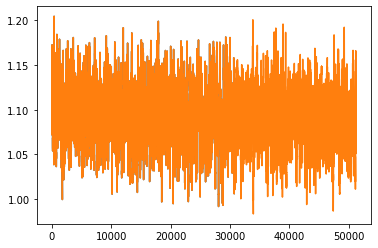

In [ ]:
alexnet_losses += train(alexnet_model, data['train'], epochs=20, lr=.0000001, verbose = 1, decay = 0.0005)

print("Training accuracy: %f" % accuracy(alexnet_model, data['train']))
print("Testing accuracy: %f" % accuracy(alexnet_model, data['test']))
plt.plot(smooth(alexnet_losses,50))
alexnet_losses += train(alexnet_model, data['train'], epochs=20, lr=.0000001, verbose = 1, decay = 0.0005)

print("Training accuracy: %f" % accuracy(alexnet_model, data['train']))
print("Testing accuracy: %f" % accuracy(alexnet_model, data['test']))
plt.plot(smooth(alexnet_losses,50))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0/5 [00:00<?, ?it/s]

[1,   100] loss: 2.192
[1,   200] loss: 1.513
[1,   300] loss: 1.377
[1,   400] loss: 1.355
[1,   500] loss: 1.350
[1,   600] loss: 1.272
[1,   700] loss: 1.242
[1,   800] loss: 1.208
[1,   900] loss: 1.173
[1,  1000] loss: 1.168


 20%|██        | 1/5 [03:09<12:38, 189.55s/it]

[2,   100] loss: 1.135
[2,   200] loss: 1.109
[2,   300] loss: 1.087
[2,   400] loss: 1.089
[2,   500] loss: 1.079
[2,   600] loss: 1.084
[2,   700] loss: 1.044
[2,   800] loss: 1.069
[2,   900] loss: 1.065
[2,  1000] loss: 0.996


 40%|████      | 2/5 [06:25<09:34, 191.35s/it]

[3,   100] loss: 1.022
[3,   200] loss: 0.992
[3,   300] loss: 0.985
[3,   400] loss: 1.009
[3,   500] loss: 0.994
[3,   600] loss: 0.990
[3,   700] loss: 0.976
[3,   800] loss: 0.970
[3,   900] loss: 0.996
[3,  1000] loss: 0.978


 60%|██████    | 3/5 [09:40<06:25, 192.65s/it]

[4,   100] loss: 0.964
[4,   200] loss: 0.950
[4,   300] loss: 0.958
[4,   400] loss: 0.969
[4,   500] loss: 0.926
[4,   600] loss: 0.966
[4,   700] loss: 0.892
[4,   800] loss: 0.918
[4,   900] loss: 0.899
[4,  1000] loss: 0.923


 80%|████████  | 4/5 [12:56<03:13, 193.61s/it]

[5,   100] loss: 0.927
[5,   200] loss: 0.900
[5,   300] loss: 0.914
[5,   400] loss: 0.872
[5,   500] loss: 0.881
[5,   600] loss: 0.913
[5,   700] loss: 0.866
[5,   800] loss: 0.869
[5,   900] loss: 0.864
[5,  1000] loss: 0.880


100%|██████████| 5/5 [16:12<00:00, 194.50s/it]


Training accuracy: 0.712091
Testing accuracy: 0.704614


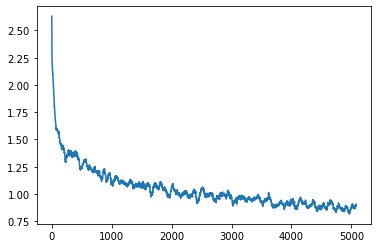

In [ ]:
#VGG16 transfer learning 
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096,14)
vgg16_loss = train(vgg16, data['train'], epochs=5, lr=.0001, verbose = 1)
print("Training accuracy: %f" % accuracy(vgg16, data['train']))
print("Testing accuracy: %f" % accuracy(vgg16, data['test']))

plt.plot(smooth(vgg16_loss,50))

  0%|          | 0/5 [00:00<?, ?it/s]

[1,   100] loss: 0.842
[1,   200] loss: 0.791
[1,   300] loss: 0.780
[1,   400] loss: 0.849
[1,   500] loss: 0.834
[1,   600] loss: 0.840
[1,   700] loss: 0.790
[1,   800] loss: 0.848
[1,   900] loss: 0.827
[1,  1000] loss: 0.833


 20%|██        | 1/5 [03:15<13:02, 195.72s/it]

[2,   100] loss: 0.807
[2,   200] loss: 0.834
[2,   300] loss: 0.808
[2,   400] loss: 0.796
[2,   500] loss: 0.831
[2,   600] loss: 0.802
[2,   700] loss: 0.813
[2,   800] loss: 0.793
[2,   900] loss: 0.845
[2,  1000] loss: 0.798


 40%|████      | 2/5 [06:31<09:47, 195.76s/it]

[3,   100] loss: 0.826
[3,   200] loss: 0.814
[3,   300] loss: 0.783
[3,   400] loss: 0.809
[3,   500] loss: 0.824
[3,   600] loss: 0.780
[3,   700] loss: 0.797
[3,   800] loss: 0.815
[3,   900] loss: 0.788
[3,  1000] loss: 0.824


 60%|██████    | 3/5 [09:47<06:31, 195.79s/it]

[4,   100] loss: 0.826
[4,   200] loss: 0.795
[4,   300] loss: 0.801
[4,   400] loss: 0.804
[4,   500] loss: 0.811
[4,   600] loss: 0.794
[4,   700] loss: 0.785
[4,   800] loss: 0.775
[4,   900] loss: 0.809
[4,  1000] loss: 0.793


 80%|████████  | 4/5 [13:03<03:15, 195.77s/it]

[5,   100] loss: 0.795
[5,   200] loss: 0.813
[5,   300] loss: 0.780
[5,   400] loss: 0.804
[5,   500] loss: 0.779
[5,   600] loss: 0.797
[5,   700] loss: 0.769
[5,   800] loss: 0.816
[5,   900] loss: 0.838
[5,  1000] loss: 0.783


100%|██████████| 5/5 [16:18<00:00, 195.80s/it]


Training accuracy: 0.731541
Testing accuracy: 0.716758


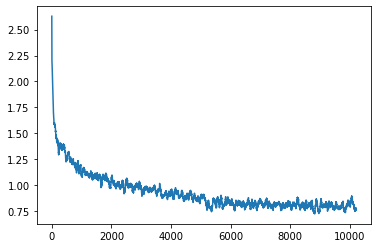

In [ ]:
vgg16_loss += train(vgg16, data['train'], epochs=5, lr=.00001, verbose = 1)
print("Training accuracy: %f" % accuracy(vgg16, data['train']))
print("Testing accuracy: %f" % accuracy(vgg16, data['test']))

plt.plot(smooth(vgg16_loss,50))

In [ ]:
vgg16_loss += train(vgg16, data['train'], epochs=5, lr=.0000001, verbose = 1)
print("Training accuracy: %f" % accuracy(vgg16, data['train']))
print("Testing accuracy: %f" % accuracy(vgg16, data['test']))

  0%|          | 0/5 [00:00<?, ?it/s]

[1,   100] loss: 0.824
[1,   200] loss: 0.814
[1,   300] loss: 0.801
[1,   400] loss: 0.781
[1,   500] loss: 0.777
[1,   600] loss: 0.768
[1,   700] loss: 0.746
[1,   800] loss: 0.798
[1,   900] loss: 0.807
[1,  1000] loss: 0.791


 20%|██        | 1/5 [03:15<13:02, 195.68s/it]

[2,   100] loss: 0.764
[2,   200] loss: 0.792
[2,   300] loss: 0.794
[2,   400] loss: 0.810
[2,   500] loss: 0.786
[2,   600] loss: 0.787
[2,   700] loss: 0.790
[2,   800] loss: 0.778
[2,   900] loss: 0.793
[2,  1000] loss: 0.775


 40%|████      | 2/5 [06:31<09:47, 195.75s/it]

[3,   100] loss: 0.789
[3,   200] loss: 0.819
[3,   300] loss: 0.772
[3,   400] loss: 0.766
[3,   500] loss: 0.787
[3,   600] loss: 0.767
[3,   700] loss: 0.765
[3,   800] loss: 0.775
[3,   900] loss: 0.795
[3,  1000] loss: 0.824


 60%|██████    | 3/5 [09:47<06:31, 195.80s/it]

[4,   100] loss: 0.810
[4,   200] loss: 0.790
[4,   300] loss: 0.776
[4,   400] loss: 0.839
[4,   500] loss: 0.773
[4,   600] loss: 0.774
[4,   700] loss: 0.793
[4,   800] loss: 0.760
[4,   900] loss: 0.788
[4,  1000] loss: 0.769


 80%|████████  | 4/5 [13:03<03:15, 195.81s/it]

[5,   100] loss: 0.786
[5,   200] loss: 0.789
[5,   300] loss: 0.791
[5,   400] loss: 0.799
[5,   500] loss: 0.811
[5,   600] loss: 0.735
[5,   700] loss: 0.802
[5,   800] loss: 0.775
[5,   900] loss: 0.764
[5,  1000] loss: 0.789


100%|██████████| 5/5 [16:19<00:00, 195.87s/it]


Training accuracy: 0.733827
Testing accuracy: 0.724347
